### Analysis about the current US fuel cycle
Includes each of the current reactors and their decommissioning, based on license expirations. This notebook looks specifically at the amount of fuel and enriched U that is required by the current fuel cycle.

In [1]:
! rm ../outputs/united_states_2020.sqlite
! cyclus -i ../inputs/united_states_2020.xml -o ../outputs/united_states_2020.sqlite

              :                                                               
          .CL:CC CC             _Q     _Q  _Q_Q    _Q    _Q              _Q   
        CC;CCCCCCCC:C;         /_\)   /_\)/_/\\)  /_\)  /_\)            /_\)  
        CCCCCCCCCCCCCl       __O|/O___O|/O_OO|/O__O|/O__O|/O____________O|/O__
     CCCCCCf     iCCCLCC     /////////////////////////////////////////////////
     iCCCt  ;;;;;.  CCCC                                                      
    CCCC  ;;;;;;;;;. CClL.                          c                         
   CCCC ,;;       ;;: CCCC  ;                   : CCCCi                       
    CCC ;;         ;;  CC   ;;:                CCC`   `C;                     
  lCCC ;;              CCCC  ;;;:             :CC .;;. C;   ;    :   ;  :;;   
  CCCC ;.              CCCC    ;;;,           CC ;    ; Ci  ;    :   ;  :  ;  
   iCC :;               CC       ;;;,        ;C ;       CC  ;    :   ; .      
  CCCi ;;               CCC        ;;;.      .C ;   

Experimental Warning: MatlBuyPolicy is experimental and its API may be subject to change
Experimental Warning: MatlSellPolicy is experimental and its API may be subject to change
Experimental Warning: The Storage Facility is experimental.
Experimental Warning: MatlBuyPolicy is experimental and its API may be subject to change
Experimental Warning: MatlSellPolicy is experimental and its API may be subject to change
Experimental Warning: The Storage Facility is experimental.
Experimental Warning: MatlBuyPolicy is experimental and its API may be subject to change
Experimental Warning: MatlSellPolicy is experimental and its API may be subject to change
Experimental Warning: The Storage Facility is experimental.
Experimental Warning: MatlBuyPolicy is experimental and its API may be subject to change
Experimental Warning: MatlSellPolicy is experimental and its API may be subject to change
Experimental Warning: The Storage Facility is experimental.
Experimental Warning: MatlBuyPolicy is exper

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

In [2]:
import cymetric as cym
from cymetric import timeseries
from cymetric import filters

## Reactors Built and Decommissioned

This section plots the number of each reacotor type in the simulation as a function of time

In [153]:
def get_metrics(filename):
    '''
    Opens database using cymetric and evaluates metrics
    
    Parameters:
    -----------
    filename: str
        relative path of database
        
    Outputs:
    --------
    evaler: Evaluator object
        contains all of the metrics of the database
    '''
    
    db = cym.dbopen(filename)
    evaler = cym.Evaluator(db, write=False)
    return evaler


def rx_commission_decommission(filename):
    '''
    Creates new column for the total number of 
    each reactor type duirng a specified simulation
    
    Parameters:
    -----------
    filename: str
        string of file name, relative path to this notebook
        
    Returns:
    simulation_data: DataFrame
        Reactor data of the simulation with the additional 
        columns of reactor totals
    '''
    evaler = get_metrics(filename)
    comm = evaler.eval('BuildSeries')
    decomm = evaler.eval('DecommissionSeries')

    # make exit counts negative for plotting purposes
    neg = -decomm['Count']
    decomm = decomm.drop('Count', axis=1)
    decomm = pd.concat([decomm, neg], axis=1)

    # for later merge, rename time columns
    comm.rename(columns={'EnterTime' : 'Time'}, inplace=True)
    decomm.rename(columns={'ExitTime' : 'Time'}, inplace =True)

    # pivot tables for plotting purposes, and merge tables
    c = comm.pivot('Time', 'Prototype')['Count'].reset_index()
    d = decomm.pivot('Time', 'Prototype')['Count'].reset_index()
    simulation_data = pd.merge(c, d, left_on='Time', right_on='Time', how='outer', sort=True,
        suffixes=('_enter', '_exit')).fillna(0)
    simulation_data['reactor_total'] = (simulation_data.sum(axis=1) - simulation_data['Time']).cumsum()
    simulation_data.Time = simulation_data.Time.astype(int)
    
    return simulation_data


current_us = rx_commission_decommission('../outputs/united_states_2020.sqlite')

In [156]:
def add_year(df):
    '''
    Adds column of Year, based on the Time colunm
    
    Parameters:
    -----------
    df: DataFrame
        DataFrame of data to add column to
        
    Outputs:
    --------
    df: DataFrame 
        DataFrame with the added column
    '''
    df['Year'] = pd.Series([np.nan for x in range(len(df.index))], index=df.index)
    for index, row in df.iterrows():
        if df['Time'][index] % 12 == 0:
            df['Year'][index] = df['Time'][index]/12 + 1985
    df['Year'] = df['Year'].fillna(method='ffill')
    return df

In [167]:
# Plot for current US fuel cycle
def plot_metric(dataframe, columns, labels):
    '''
    Plots line graph of the specified column from the given 
    DataFrame as a function of time.
    
    Parameters:
    -----------
    dataframe: DataFrame
        data from simulation
    columns: list of str
        names of columns to be plotted, first element
        is the x-axis
    labels: list of str
        label names in the order: 
            1. y-axis label
            2. Legend title
            3-end: legend labels
    
    Outputs:
    --------
    Figure of desired metric as a function of time
    '''
    dataframe[columns].plot(x = columns[0], figsize=(30, 10), legend=False)
    
    l = plt.legend()
    for ii in range(2,len(labels)):
        l.get_texts()[ii-2].set_text(labels[ii])
    l.set_title(labels[1])
    
    plt.xlabel(r'Time Step', fontsize=18); plt.ylabel(labels[0], fontsize=18)
    plt.show()
    
    return 

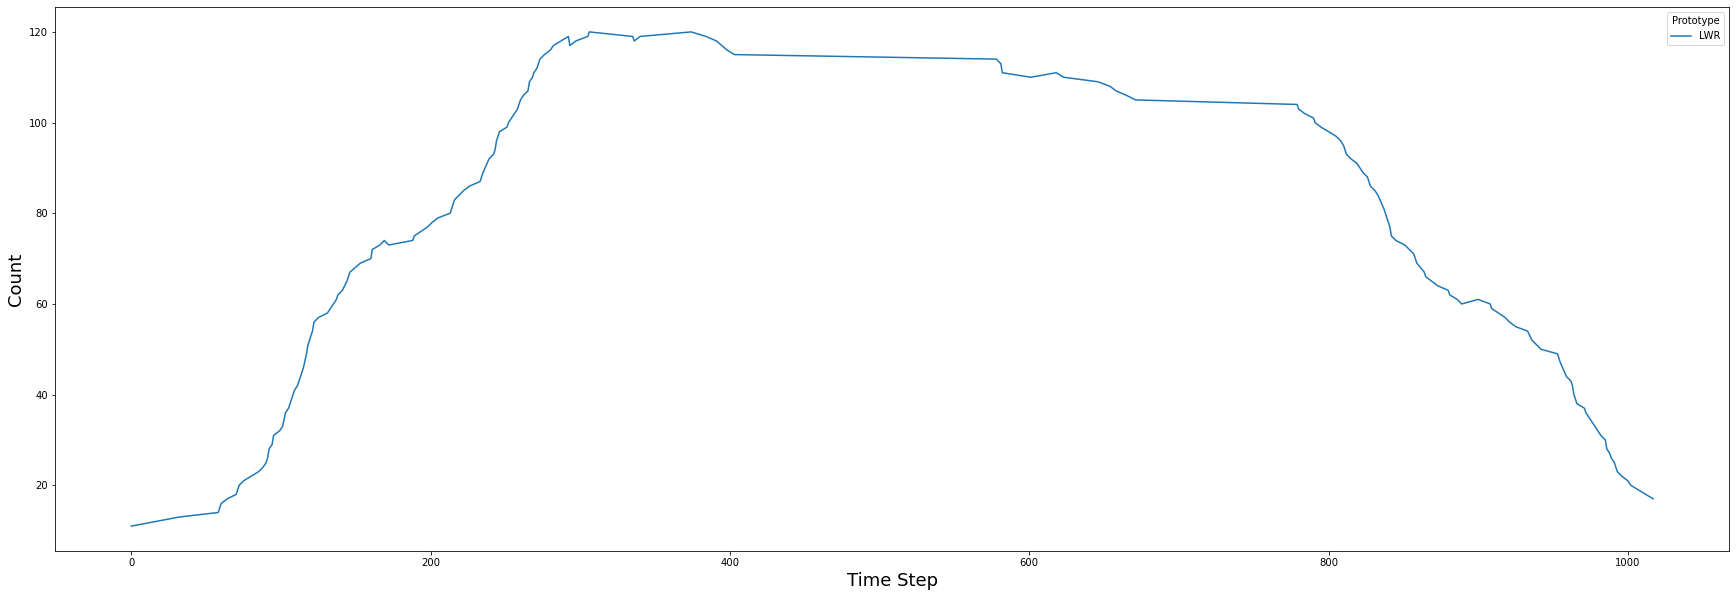

In [168]:
plot_metric(current_us, ['Time','reactor_total'], ['Count','Prototype', 'LWR'])

# Calculating annual throughputs

In [162]:
def get_transactions(filename):
    '''
    Gets the TransactionQuantity metric from cymetric, 
    sorts by TimeCreated, and renames the TimeCreated 
    column
    
    Parametrs:
    ----------
    filename: str
        relative path to database
        
    Outputs:
    --------
    transactions: DataFrame
        transaction data with specified modifications    
    '''
    evaler = get_metrics(filename)
    transactions = evaler.eval('TransactionQuantity').sort_values(by='TimeCreated')
    transactions = transactions.rename(columns={'TimeCreated':'Time'})
    return transactions

def calculate_throughput(filename, commodity):
    '''
    Calculates the total amount of a commodity traded 
    at each time step
    
    Parameters:
    -----------
    filename: str
        database file name
    commodity: str
        commodity name
    
    Outputs:
    --------
    total_commodity: DataFrame
        DataFrame of total amount of each 
        commodity traded as a function of time
    '''
    transactions = get_transactions(filename)
    transactions[commodity] = transactions.loc[transactions['Commodity']==commodity]['Quantity']
    transactions[commodity].fillna(value=0, inplace=True)
    total_commodity = transactions[['Time',commodity,'Units']]
    total_commodity = total_commodity.groupby(total_commodity['Time']).aggregate({'Time':'first',
                                                            commodity:'sum', 'Units':'first'})
    return total_commodity

## Calculating annual enriched U supplied by enrichment facility (product)

In [163]:
enriched_u = calculate_throughput('../outputs/united_states_2020.sqlite', 'enr_u')

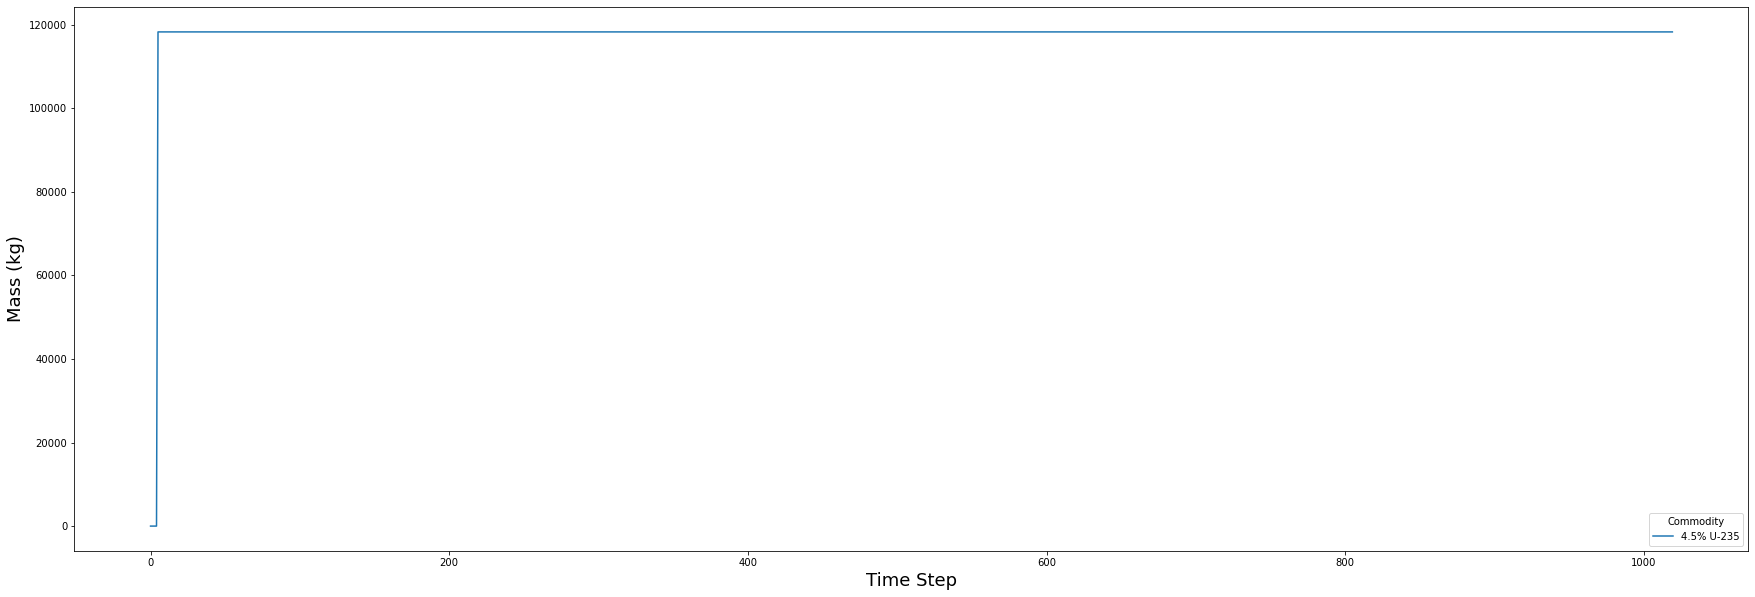

In [169]:
plot_metric(enriched_u, ['Time', 'enr_u'], ['Mass (kg)','Commodity', '4.5% U-235'])

## Calculating annual feed material

In [170]:
uf6 = calculate_throughput('../outputs/united_states_2020.sqlite', 'uf6')

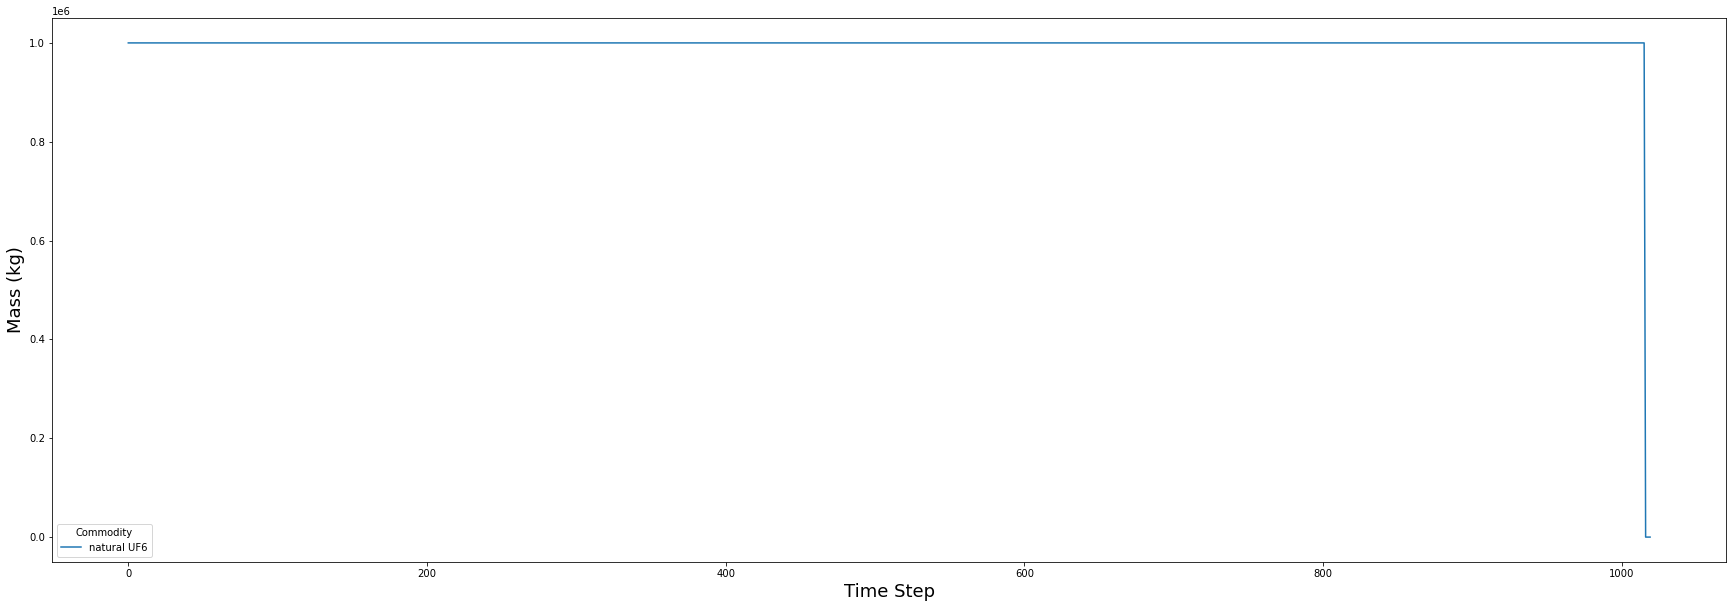

In [171]:
plot_metric(uf6, ['Time', 'uf6'], ['Mass (kg)','Commodity', 'natural UF6'])

## Calculating annual tails production

In [172]:
tails = calculate_throughput('../outputs/united_states_2020.sqlite', 'tails')

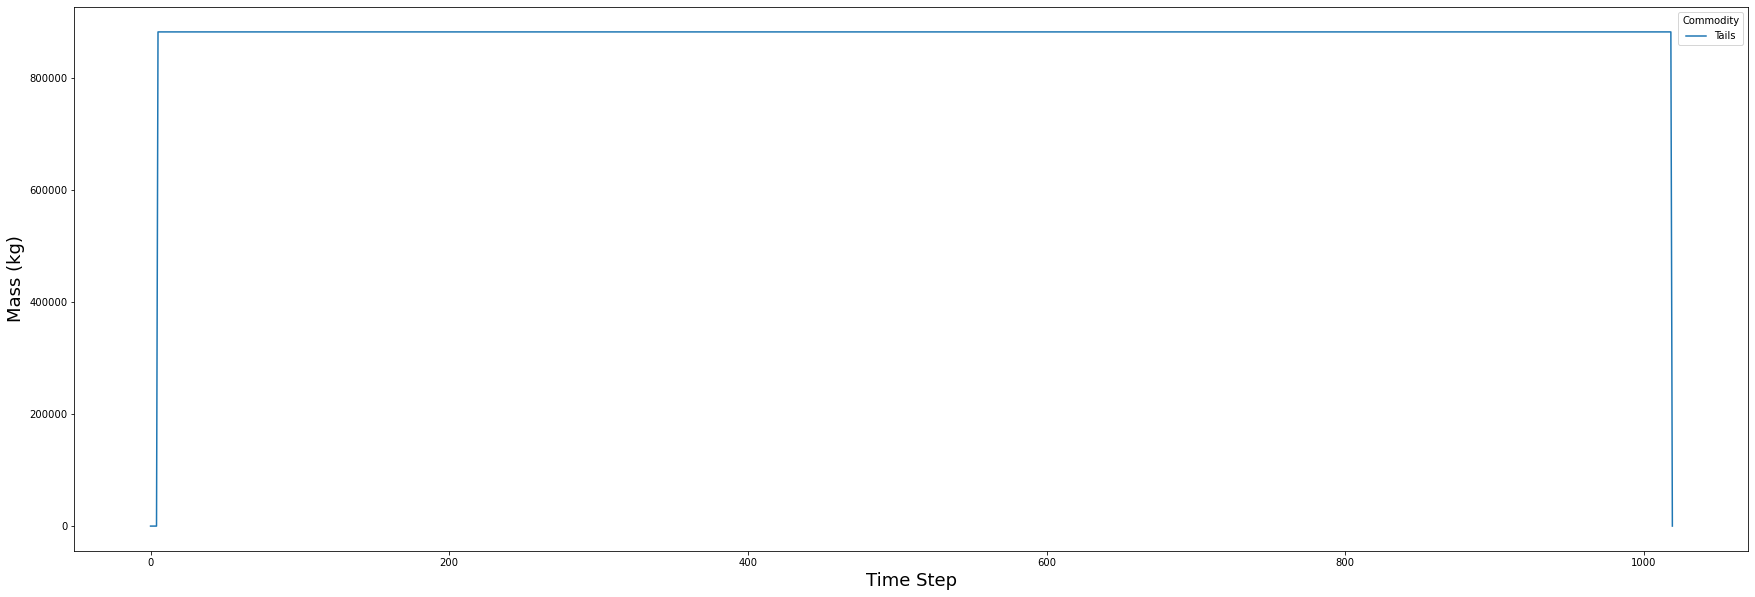

In [174]:
plot_metric(tails, ['Time', 'tails'], ['Mass (kg)','Commodity', 'Tails'])

## Determining feed, tails, and product assay

In [178]:
#Defining assays
x_p = 0.045
x_f = 0.00711
x_t = 0.002

## SWU Calculation
SWU = (P*V(x_p) + T*V(x_t) - F*V(x_f))*t

V(x_i) = (2*x_i-1)*ln(x_i/(1-x_i))

In [180]:
def separation_potential(x_i):
    '''
    Calculates Separation Potentail, for use in calculating 
    Separative Work Units (SWU) required for enrichment level
    
    Inputs:
    -------
    x_i: int
        mass fraction of a generic mass stream
    
    Returns:
    --------
    v: int
        Separation potential
    '''
    v = (2*x_i - 1) * np.log(x_i/(1-x_i))
    return v
    
def calculate_SWU(P, x_p, T, x_t, F, x_f):
    '''
    Calculates Separative Work Units required to produce
    throughput of product given mass of feed and tails and
    assay of each mass stream
    
    Parameters:
    -----------
    P: int
        mass of product
    x_p: int
        weight percent of U-235 in product
    T: int
        mass of tails
    x_t: int
        weight percent of U-235 in tails
    F: int
        mass of feed
    x_f: int
        weight percent of U-235 in feed
    
    Outputs:
    --------
    SWU: int
        Separative Work units per unit time 
    '''
    SWU = P*separation_potential(x_p) + T*separation_potential(x_t) - \
          F*separation_potential(x_f)
    return SWU

In [181]:
calculate_SWU(100, x_p, 742.94, x_t, 842.94, x_f)

770.9640826377063